In [1]:
%run 'init.ipynb'
save = get_figsave(5)

In [42]:
def lorenz(x, y, z, sigma=10, beta=8/3, rho=28):
    return np.array((
        sigma*(y-x),
        x*(rho-z) - y,
        x*y - beta*z,
    ))


def f_lorenz(t, y):
    return lorenz(y[0], y[1], y[2])


def jac_lorenz(x, y, z, sigma=10, beta=8/3, rho=28):
    return np.array((
        (  -sigma,  sigma,   0   ),
        ( rho - z,     -1,  -x   ),
        (       y,      x,  -beta),
    ))


def f_full_lorenz(t, y):
    dydx = np.zeros_like(y)
    dydx[:3] = lorenz(y[0], y[1], y[2])
    dx = np.reshape(y[3:], (3,3))
    dx_at_jac = jac_lorenz(y[0], y[1], y[2]) @ dx
    dydx[3:] = np.reshape(dx_at_jac, 9)
    return dydx

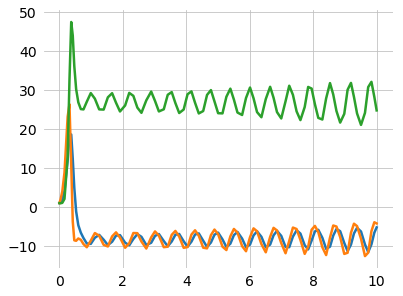

In [43]:
y0 = (1,1,1)
sol = solve_ivp(f_lorenz, (0, 10), y0)
for i in range(3):
    plt.plot(sol.t, sol.y[i,:])

In [101]:
from scipy.integrate import solve_ivp

# f = fun(t, y)
# y0 = a phase point
# st = dt = time step
# kkmax = imax = max iter

def lyapunov(f, y0, dt=0.01, imax=1000):
    
    y0 = np.array(y0)
    
    # Dimensionality (== 3)
    n = y0.size

    # Initialise singular value sums to 0
    log_sv_cumul = np.zeros(n)

    # Container to track Lyaponov exponent convergence
    LE = np.zeros((imax, n))

    # Initialise tangent vectors as columns of identity matrix
    U = np.eye(n)

    # Integrate ODE & tangent vectors over dt,
    # then Gram-Schmidt orthogonalise ( {vecs}   -->   {orthogonal vecs} that span same space )
    for it in range(imax):
        t = it*dt
        # Long column vector containing phase point and tangent vectors
        var = np.concatenate([y0, np.reshape(U, n*n)])
        # Solve ODE for phase point and tangent vectors
        # var_new = solve_ivp(f, (t-dt, t), var, t_eval=[t], method='RK23').y[:,0]
        var_new = var + f(t, var) * dt
        # Recover new phase point and tangent vectors
        y0 = var_new[:n]
        dx = np.reshape(var_new[n:], (n,n))
        # GS-orthogonalise tangent vectors
        # U, s, _ = np.linalg.svd(dx)
        V = np.zeros_like(dx)
        for i in range(n):
            V[:,i] = dx[:,i]
            for j in range(i):
                dotp = V[:,i].T @ U[:,j]
                V[:,i] -= dotp * U[:,j]
            veclen = np.sqrt(V[:,i].T @ V[:,i])
            U[:,i] = V[:,i] / veclen
            log_sv_cumul[i] += np.log(veclen)
            LE[it,i] += log_sv_cumul[i] / t
            
        # Accumulate logs of singular values
        # log_sv_cumul += np.log(s)
        # Division by current time yields Lyapunov exponents
        # LE[it,:] = log_sv_cumul / t
    
    fig, ax = plt.subplots()
    for i in range(3):
        ax.plot(np.arange(imax)+1, LE[:,i])
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Lyapunov exponent')
    return fig, ax, LE[-1,:]

/root/conda/envs/swr-detect/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: divide by zero encountered in double_scalars


[0.789 -0.0724 -14.7]


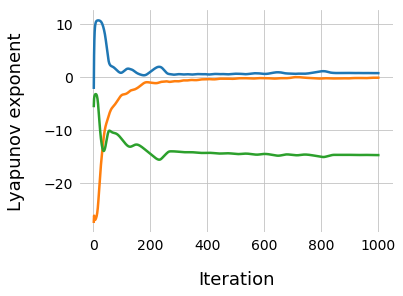

In [117]:
fig, ax, LE = lyapunov(f_full_lorenz, y0=(1,1,1), dt=0.01, imax=1000)
print(LE)
# save(fig, 'LE_Lorenz')